# Sentiment Analysis (CV-TF_IDF-HASH) 

In [20]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

import pickle

import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [22]:
# Read the file
df3 = pd.read_csv('data/Reduced_Cleaned_Reviews.csv')

In [23]:
# Sample observations
df3.head(3)

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review_text,clean_text,date_correct,year,rating_class_num,token,review_length,review_length_bin
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),True,True,5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,2012-11-30 06:21:45+00:00,2012,1,"['awesome', 'love', 'album', 'good', 'hip', 'h...",50,"(0, 100]"
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,False,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,2017-07-09 00:00:00+00:00,2017,1,"['good', 'good', 'flavor', 'review', 'collect'...",14,"(0, 100]"
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...,2016-01-06 00:00:00+00:00,2016,0,"['disappoint', 'read', 'review', 'look', 'buy'...",144,"(100, 200]"


In [24]:
# Drop unnecessary columns
df4 = df3.drop(['brand','categories','manufacturer','name','reviews_didPurchase','reviews_doRecommend','reviews_rating','date_correct','rating_class_num','review_length', 'review_length_bin'], axis=1)

In [25]:
df4.head()

,id,reviews_username,user_sentiment,review_text,clean_text,year,token
0,AV13O1A8GV-KLJ3akUyj,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,2012,"['awesome', 'love', 'album', 'good', 'hip', 'h..."
1,AV14LG0R-jtxr-f38QfS,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,2017,"['good', 'good', 'flavor', 'review', 'collect'..."
2,AV16khLE-jtxr-f38VFn,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...,2016,"['disappoint', 'read', 'review', 'look', 'buy'..."
3,AV16khLE-jtxr-f38VFn,walker557,Negative,Irritation My husband bought this gel for us. ...,irritation husband buy gel us gel cause irrita...,2016,"['irritation', 'husband', 'buy', 'gel', 'us', ..."
4,AV16khLE-jtxr-f38VFn,samantha,Negative,Not worth it My boyfriend and I bought this to...,not worth boyfriend buy spice things bedroom h...,2016,"['not', 'worth', 'boyfriend', 'buy', 'spice', ..."


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers.

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

### Separating Response Variable and Feature

In [26]:
df4['user_sentiment'] = df4['user_sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [27]:
# Splitting the Data Set into Train and Test Sets
X = df4['clean_text']
y = df4['user_sentiment']

### Splitting Dataset into Train and Test Set

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [28]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(11250,)
Test Set Shape		:(3750,)


## 3. Selecting the Right Evaluation Metric

Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

### Confusion Matrix Plot Function

Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'Positive' and 'Negative' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [31]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST algorithms. Besides that, I implemented deep learning technique with Keras.

Since the ratings of the reviews were not distributed normally, I decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Negative’ and Rating 3-4-5 as 'Positive'.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

## 4.1 CountVectorizer Bag of Words

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [32]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [33]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 7655


In [34]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [35]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,aaa,aaaaahhhhhh,aalot,abc,abcess,abd,abilities,ability,able,abrasion,...,ziploc,ziplock,zombie,zombieaction,zombiemutantundead,zombies,zombified,zone,zoo,zorbas
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating a function for applying different algorithms

In [38]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
    return model

### 4.1.1 Logistic Regression with CountVectorizer

In [39]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8826217203078227


#### Classification Report

In [40]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.44      0.82      0.58       416
           1       0.98      0.87      0.92      3334

    accuracy                           0.87      3750
   macro avg       0.71      0.85      0.75      3750
weighted avg       0.92      0.87      0.88      3750



#### Confusion Matrix

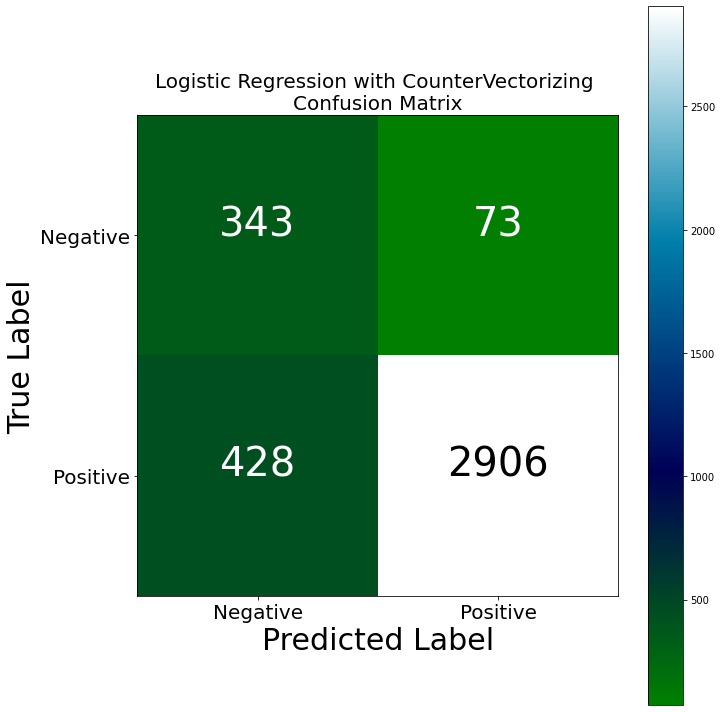

In [41]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer¶

In [42]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8722604653532502


#### Classification Report

In [43]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.84      0.16      0.26       416
           1       0.90      1.00      0.95      3334

    accuracy                           0.90      3750
   macro avg       0.87      0.58      0.61      3750
weighted avg       0.90      0.90      0.87      3750



#### Confusion Matrix

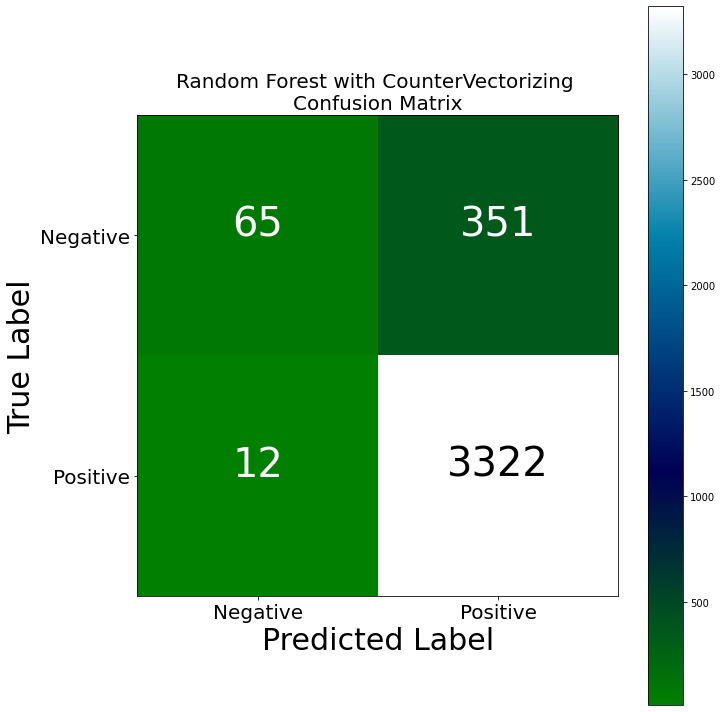

In [44]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer

In [45]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8700623981312304


#### Classification Report

In [46]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.46      0.27      0.34       416
           1       0.91      0.96      0.94      3334

    accuracy                           0.88      3750
   macro avg       0.68      0.62      0.64      3750
weighted avg       0.86      0.88      0.87      3750



#### Confusion Matrix

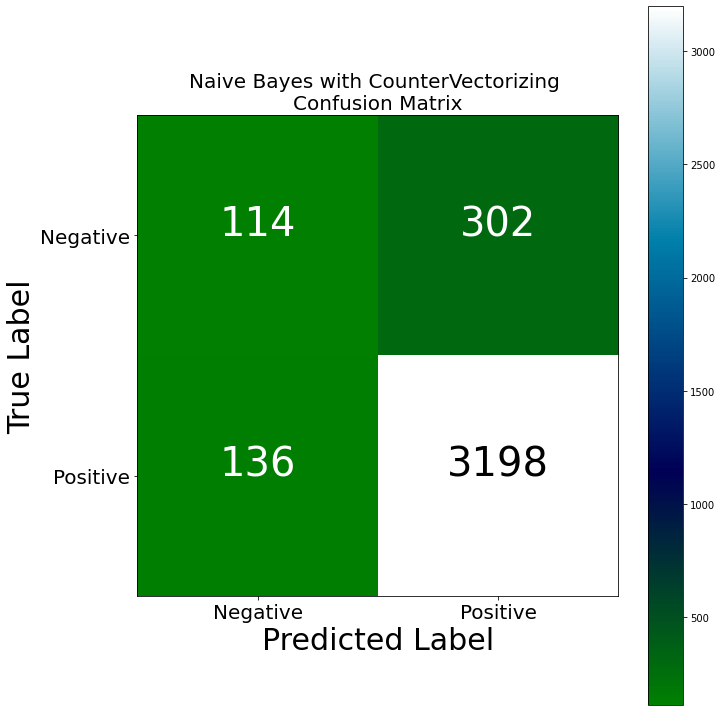

In [47]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [48]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

[13:10:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9100696812238662


#### Classification Report

In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.74      0.43      0.54       416
           1       0.93      0.98      0.96      3334

    accuracy                           0.92      3750
   macro avg       0.84      0.70      0.75      3750
weighted avg       0.91      0.92      0.91      3750



#### Confusion Matrix

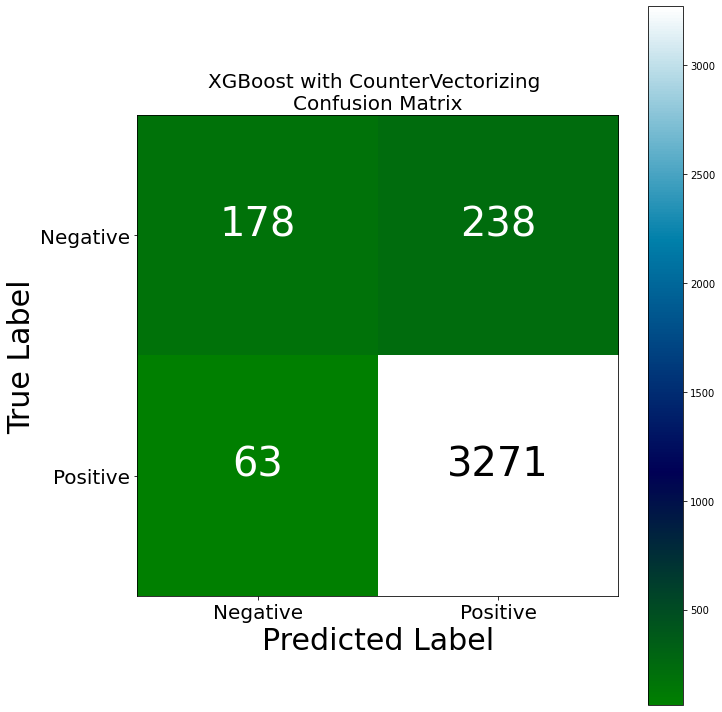

In [50]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.6 Comparison of Models with CountVectorizer

In [51]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [52]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Function for f1 Score Plotting

In [53]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

### Algorithms Comparison with CountVectorizer

In [55]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

In [56]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.866400 bad       0.444877  0.824519  0.577928   
                                  good      0.975495  0.871626  0.920640   
                                  average   0.916632  0.866400  0.882622   
           Random Forest 0.903200 bad       0.844156  0.156250  0.263692   
                                  good      0.904438  0.996401  0.948195   
                                  average   0.897751  0.903200  0.872260   
           Naive Bayes   0.883200 bad       0.456000  0.274038  0.342342   
                                  good      0.913714  0.959208  0.935909   
                                  average   0.862939  0.883200  0.870062   
           XGBoost       0.919733 bad       0.738589  0.427885  0.541857   
                                  good      0.932174  0.981104  0.956013   
                                  average   0.910699  0.919733  0.910070   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.866400 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           Random Forest 0.903200 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           Naive Bayes   0.883200 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           XGBoost       0.919733 bad        416.0  
                                  good      3334.0  
                                  average   3750.0

### Average f1 Score - Models with CountVectorizer

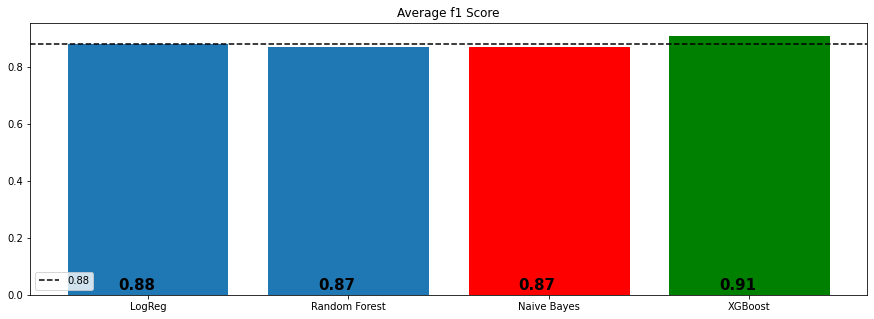

In [57]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

## 4.2 TF-IDF

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [58]:
# Create the word vector with TF-IDF Vectorizer
stopset = set(stopwords.words('english'))
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1),stop_words=stopset)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
pickle.dump(tfidf_vect, open('model/tranform.pkl', 'wb'))

tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()




In [59]:
# Print vocabulary length
print('Vocabulary length :', len(tfidf_vect.get_feature_names()))

Vocabulary length : 7643


In [60]:
# Assign feature names of vector into a variable
vocab = tfidf_vect.get_feature_names()

In [61]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(tfidf_vect_train, columns = vocab).head()

,aaa,aaaaahhhhhh,aalot,abc,abcess,abd,abilities,ability,able,abrasion,...,ziploc,ziplock,zombie,zombieaction,zombiemutantundead,zombies,zombified,zone,zoo,zorbas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.2.1 Logistic Regression with TF-IDF

In [62]:

# Call the modeling function for logistic regression with TF-IDF and print f1 score
logistic_model = modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8318727622901493


#### Classification Report

In [63]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.34      0.83      0.48       416
           1       0.97      0.80      0.88      3334

    accuracy                           0.80      3750
   macro avg       0.66      0.81      0.68      3750
weighted avg       0.90      0.80      0.83      3750



#### Confusion Matrix

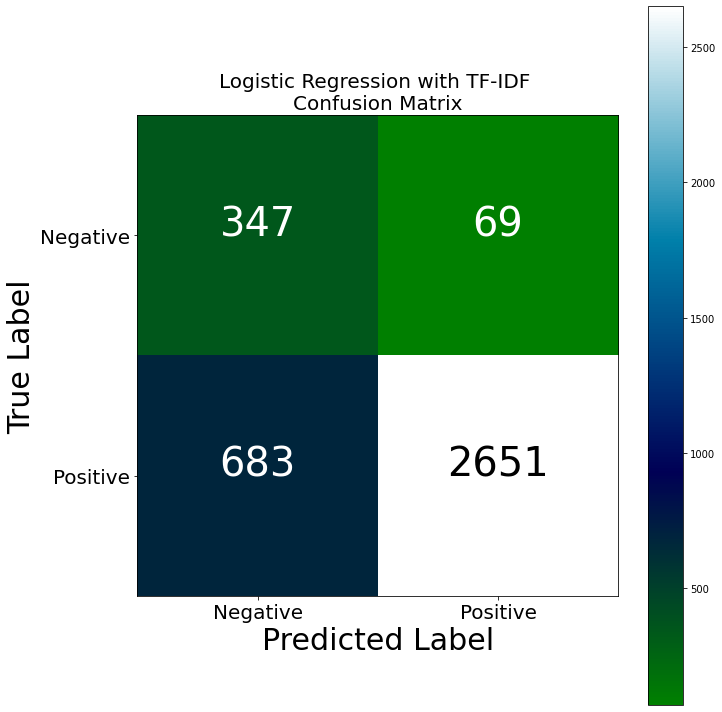

In [64]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [65]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
random_forest_model = modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8640603242663808


#### Classification Report

In [66]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.82      0.12      0.21       416
           1       0.90      1.00      0.95      3334

    accuracy                           0.90      3750
   macro avg       0.86      0.56      0.58      3750
weighted avg       0.89      0.90      0.86      3750



#### Confusion Matrix

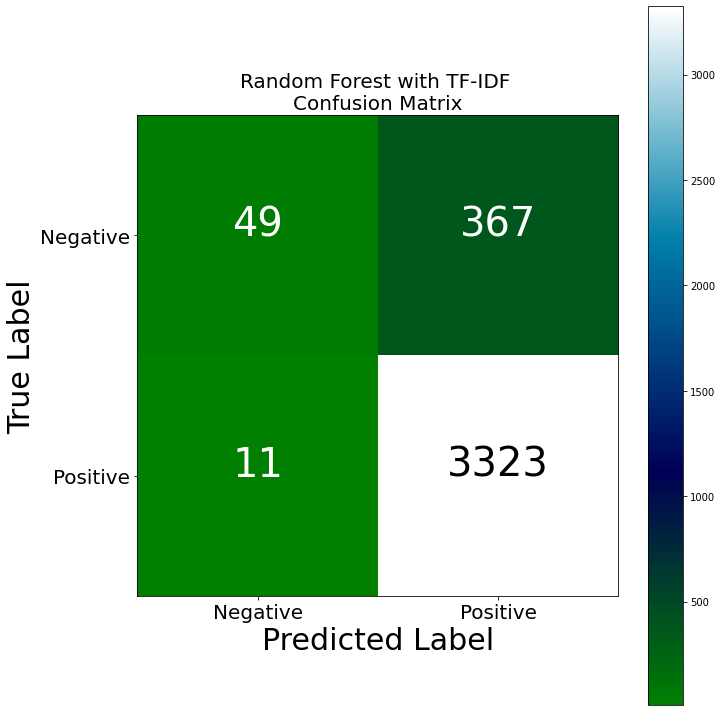

In [67]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [68]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
naive_bayes_model = modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8368572181441746


#### Classification Report

In [69]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       416
           1       0.89      1.00      0.94      3334

    accuracy                           0.89      3750
   macro avg       0.44      0.50      0.47      3750
weighted avg       0.79      0.89      0.84      3750



#### Confusion Matrix

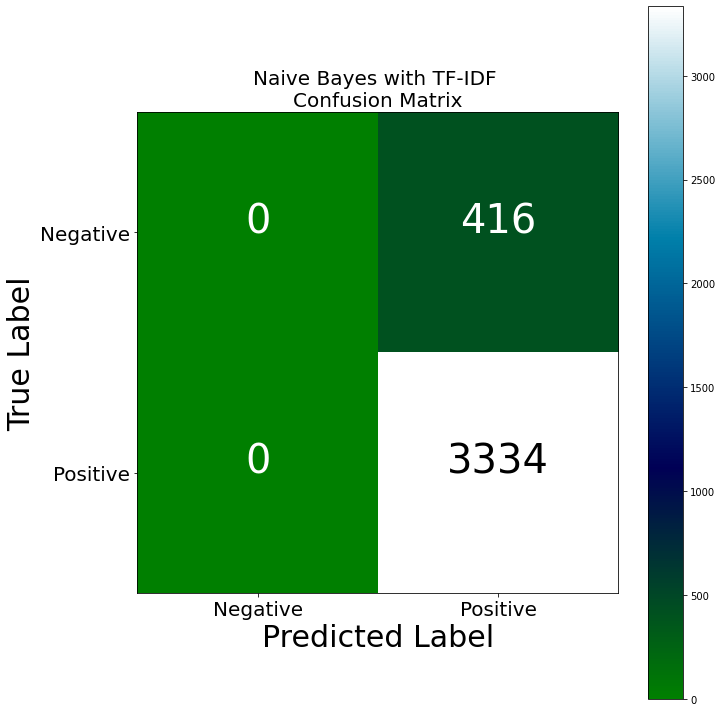

In [70]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [71]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
XGboost_model = modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

[15:17:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9072338089653508


#### Classification Report

In [72]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.73      0.41      0.53       416
           1       0.93      0.98      0.95      3334

    accuracy                           0.92      3750
   macro avg       0.83      0.70      0.74      3750
weighted avg       0.91      0.92      0.91      3750



#### Confusion Matrix

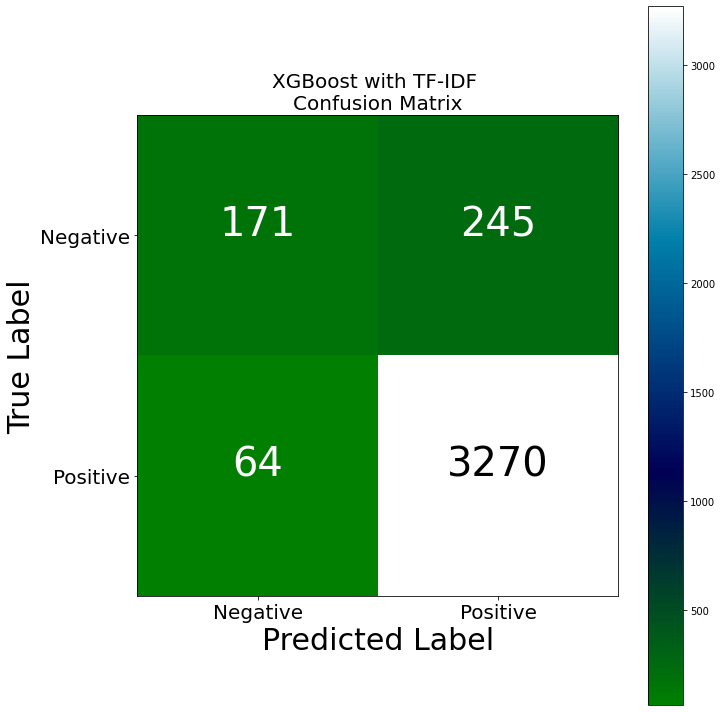

In [73]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### Algorithms Comparison with TF-IDF Vectorizer

In [74]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost'])

#### Comparison Table - TF-IDF Vectorizing

In [75]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.799467 bad       0.336893  0.834135  0.479945   
                                  good      0.974632  0.795141  0.875785   
                                  average   0.903886  0.799467  0.831873   
           Random Forest 0.899200 bad       0.816667  0.117788  0.205882   
                                  good      0.900542  0.996701  0.946185   
                                  average   0.891237  0.899200  0.864060   
           Naive Bayes   0.889067 bad       0.000000  0.000000  0.000000   
                                  good      0.889067  1.000000  0.941276   
                                  average   0.790440  0.889067  0.836857   
           XGBoost       0.917600 bad       0.727660  0.411058  0.525346   
                                  good      0.930299  0.980804  0.954884   
                                  average   0.907819  0.917600  0.907234   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.799467 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           Random Forest 0.899200 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           Naive Bayes   0.889067 bad        416.0  
                                  good      3334.0  
                                  average   3750.0  
           XGBoost       0.917600 bad        416.0  
                                  good      3334.0  
                                  average   3750.0

### Average f1 Score - Models with TF-IDF Vectorizer

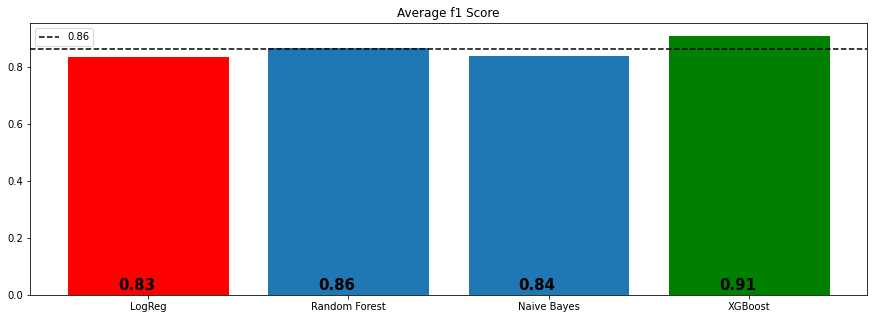

In [76]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

In [77]:
filename = 'model/nlp_XGboost_model.pkl'
pickle.dump(XGboost_model, open(filename, 'wb'))

In [78]:
# load the nlp model and tfidf vectorizer from disk
filename = 'model/nlp_XGboost_model.pkl'
clf = pickle.load(open(filename, 'rb'))
vectorizer = pickle.load(open('model/tranform.pkl','rb'))

In [79]:
movie_review_list = np.array(['disappoint read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean not pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess'])
movie_vector = vectorizer.transform(movie_review_list)
pred = clf.predict(movie_vector)
print('Positive' if pred else 'Negative')


Negative


In [80]:
movie_review_list = np.array(['One of my favorites The Hand-Cream-Lemon-Cream has such a refreshing fragrance. I wish it would last all day. It is soothing to the hands and I get compliments when I use it especially from my daughters and granddaughters, they want me to get some for them It is one of my favorite hand creams. I wish Watkins still had the vanilla body cream that too was a favorite.'])
movie_vector = vectorizer.transform(movie_review_list)
pred = clf.predict(movie_vector)
print('Positive' if pred else 'Negative')


Positive


In [81]:
movie_review_list = np.array(['Hand cream Smells like a lemon cookie. Absolutely love!!! My kids love it.'])
movie_vector = vectorizer.transform(movie_review_list)
pred = clf.predict(movie_vector)
print('Positive' if pred else 'Negative')


Positive
